In [8]:
include("../scripts/ideal_robot.jl")

In [9]:
using Distributions
using Random

In [10]:
mutable struct Camera <: AbstractCamera
    map
    lastdata
    distance_range
    direction_range
    distance_noise_rate
    direction_noise
end

In [11]:
function Camera(env_map, distance_range=(0.5,6.0), direction_range=(-pi/3, pi/3),
                distance_noise_rate=0.1, direction_noise=pi/90)
    self = Camera(ntuple(x->nothing, fieldcount(Camera))...)
    self.map = env_map
    self.lastdata = []
    self.distance_range = distance_range
    self.direction_range  = direction_range
    self.distance_noise_rate = distance_noise_rate
    self.direction_noise = direction_noise
    return self
end

Camera

In [12]:
mutable struct Robot <: AbstractRobot
    pose
    r
    color
    agent
    poses
    sensor
    noise_pdf
    distance_until_noise
    theta_noise
    bias_rate_nu
    bias_rate_omega
    stuck_pdf
    escape_pdf
    time_until_stuck
    time_until_escape
    is_stuck
    kidnap_pdf
    time_until_kidnap
    kidnap_dist
end

function Robot(pose, agent, sensor, color, noise_per_meter = 5, noise_std=pi/60,
    bias_rate_stds=(0.1,0.1), expected_stuck_time=1e100, expected_escape_time = 1e-100,
    expected_kidnap_time=1e100, kidnap_range_x=(-5.0, 5.0), kidnap_range_y=(-5.0, 5.0))
    rbt = Robot(ntuple(x->nothing, fieldcount(Robot))...)
    rbt.pose = pose
    rbt.r = 0.2
    rbt.agent = agent
    rbt.sensor = sensor
    rbt.poses = [pose]
    rbt.color = color
    rbt.noise_pdf = Exponential(1.0/(1e-100 + noise_per_meter))
    rbt.distance_until_noise = rand(rbt.noise_pdf)
    rbt.theta_noise = Normal(0, noise_std)
    rbt.bias_rate_nu = rand(Normal(1, bias_rate_stds[1]))
    rbt.bias_rate_omega = rand(Normal(1, bias_rate_stds[2]))
    rbt.stuck_pdf = Exponential(expected_stuck_time)
    rbt.escape_pdf = Exponential(expected_escape_time)
    rbt.time_until_stuck = rand(rbt.stuck_pdf)
    rbt.time_until_escape = rand(rbt.escape_pdf)
    rbt.is_stuck = false
    rbt.kidnap_pdf = Exponential(expected_kidnap_time)
    rbt.time_until_kidnap = rand(rbt.kidnap_pdf)
    rx = kidnap_range_x
    ry = kidnap_range_y
    rbt.kidnap_dist = (Uniform(rx[1], rx[2]), Uniform(ry[1], ry[2]), Uniform(0, 2*pi))
    return rbt
end

function noise(self::Robot, pose, nu, omega, time_interval)
    self.distance_until_noise -= abs(nu)*time_interval + self.r*abs(omega)*time_interval
    if self.distance_until_noise <= 0.0
        self.distance_until_noise += rand(self.noise_pdf)
        pose[3] += rand(self.theta_noise)
    end
    return pose
end

function bias(self::Robot, nu, omega)
    return nu*self.bias_rate_nu, omega*self.bias_rate_omega
end

function stuck(self::Robot, nu, omega, time_interval)
    if self.is_stuck
        self.time_until_escape -= time_interval
        if self.time_until_escape <= 0.0
            self.time_until_escape += rand(self.escape_pdf)
            self.is_stuck = false
        end
    else
        self.time_until_stuck -= time_interval
        if self.time_until_stuck <= 0.0
            self.time_until_stuck += rand(self.stuck_pdf)
            self.is_stuck = true
        end
    end
    return nu*(!self.is_stuck), omega*(!self.is_stuck)
end

function kidnap(self::Robot, pose, time_interval)
    self.time_until_kidnap -= time_interval
    if self.time_until_kidnap <= 0.0
        self.time_until_kidnap += rand(self.kidnap_pdf)
        return [rand(self.kidnap_dist[1]), rand(self.kidnap_dist[2]), rand(self.kidnap_dist[3])]
    else
        return pose
    end
end

function one_step(self::Robot, time_interval)
    if isnothing(self.agent)
        return
    end
    obs = nothing
    if !isnothing(self.sensor)
        obs = data(self.sensor, self.pose)
    end
    nu, omega = decision(self.agent, obs)
    nu, omega = bias(self, nu, omega)
    nu, omega = stuck(self, nu, omega, time_interval)
    self.pose = state_transition(self, nu, omega, time_interval)
    self.pose = noise(self, self.pose, nu, omega, time_interval)
    self.pose = kidnap(self, self.pose, time_interval)
end

one_step (generic function with 3 methods)

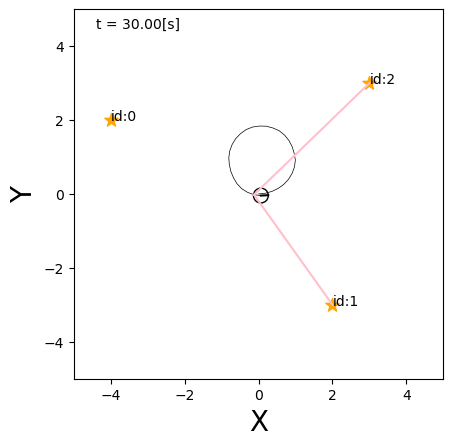

In [23]:
world = World(30, 1.0)
m = Map()
append_landmark(m, Landmark([-4.0,2.0]))
append_landmark(m, Landmark([2.0,-3.0]))
append_landmark(m, Landmark([3.0,3.0]))
append(world, m)

circling = Agent(0.2, 10.0/180*pi)
r = Robot([0.0, 0.0, 0.0], circling, Camera(m), "black")
append(world, r)
draw(world)

In [24]:
showanim("test.mp4")

<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAXjhtZGF0AAACoAYF//+c3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1NyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMTggLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MSBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAF29liIQAF//+99S3zLLtU2+2C6j3op4mX0N1JQGblsTtOoAAAAMAAAMAAB68FzgCX4kK868AAAMAyoAXqEn/CmOPiA7BC5NJlvfhKIWPSXi/zA6JYDLoQAMQkginty7NGv2twoUk3+x++sOjYLO23GkLnX3zZEYn6a9vQcRQLf67K7SBvVrJ/o4DfjcfmL80ItpTpOBk9UoqIRYyXX9Jp26SG/qkhzXvDYJnUDUkXMWTV9xgIkId/B0DL63tzWtJoDT3qBLshsubVeON8CDX6ibsLgVVQ4A0D7tGbVkDzT/KsUAH7fA8ber7HvEJfThyzrLkSWNw9QjQzXk0jYHioNxDFOC0u5P/6flbarG27qxKpcR1g3jAe/uyNQkdibir9L1oZNoxCL9nTz5Do7WCxbZi9Ea0fjbwfl2o9ts0w9wdN5MJVeAjp2apf/nrOG4XqhXEOky0ViewaAExu4pV61UcgekdA1z3mTGfHUVi7lbjNjafsSusndiXhSJn8k8VhLU7uYRjxIdQ0M5ROE4eOe0Eev0A9OOL8/r81/6uO/7gObO3O8ikho5Gmu+TSMNye6np8b69hULJzIwzgFY4798RLsws18k5UOAeCwOlWwPO/Yh7LwJnPykhJTN9kY+OpWNFg6l3by+FnBglFK53i/Q76FzranJpKNyMajWn2P0NKgYsg0pdHCtadp/QrLQFGG/Uvsnr/YYD4WRXbXE39PfEt3WXzcLIFejx4Gt+Y5vXjx9188tPzEUQ37Zw/zgwWPNpTzLqavgaCxbScarwxPCvTEfjY2IgWiCV2TAmynCCVycdvV7xluoiPfvQtuifGsCs5YeZ9J8GpdY91b9ZGS2bIeFDnNqmEVKNhTQ1ZbpLevGpqcaYqUq2aJZqun5+76fMIuZBWOyg57h83Eu+5uwLKCuIj79ymNk1XCHAzGKD3YWFWfGN5XRBrCF3tVPXNXbx9HPf8QTAAVt9Q4lyS1fqGKiT8fcx7oCYg+e87WWgWxGxw7vs8ax91yfhkAMJnm/ijKcebk3F1H2kpsn0kCw48F2x3aP+7vWcmr8RBgdKtu93Pg8f6YlhIRg4yqJ7hRTVBAn/wNHo0P2OYh45MujiyHokxlMOyCYyOJmrGi1Pbr+HEd8S6kRivgnBThXHOb6n89X5zcam54bgihQIAhL6ShJKYQ3N/aMai3EmHqi+C/D3mlOzFNGHU601JEL4mr91q5Lk2iE3esdiLVAomnC3g3qrU0VNMQg17mDeuhneEG6GbjkQV5m2FMc8xqs5QN9bguCppxpptT6UjDorQpp+X+kYtDlLjFR8ekjEDF3d2+j7B3TD1SxZYvIZM/66im0FN0U7dx3ftWg0kgELUudUJmU6BCj7WYIueUEcbyLl/BmnxGVVFw1hTUTg2FW9vsA3JubW4wJf2QBKNobmccdFFThX6YeFqB1wdONlC2EJfBW9fDO9gh3Nm+3agkeZYXestV1+WmSkE+HT6M6aqxROcfifh6FyrnmSQ7xOlBzBAoT7igyqyjjqBf3Rw1lHdEkPEcdOV9HvlKYNUjZM84luqnH1AhvkpzS7mv5TSaTWm2kH2AF7iUEGbRXDL+dwIG2hMYWLke6rVvV/ggEVnDzUMDiN6+DJ80VJHj/7dwhn86xOjIyLWA95horiQOaMiBY9s5Ujw90h+zfQUlPcWJx65bJm/2VGQpV+FNL8A/hevbnY9jNEQpRXPr6+KyqxBExdaWQ6sbABtybUA4JBj0mOe8wGUPyYW7+zuyBxPKYE38us3+/v7Pi96xj07B1Gy9H6qO3nfLRGgB+Ym9RwtbrgDRiBVDM9+1rn1e7wTMbwsmk2yTtWKb10EprZPH9gua9Z5SS8peeXxxImuomO1lVxZz8yo33qvW1ARSqMPt/cE24uXf1lUrUBxNEt4ciQ3F51fqUkt3Hp3N+uGV/yY+4I5LNv1HhSD+NGtUGUTUKZ5RhvJum0mT8Os1oOSnfkihayAhkxdMHUuTMeCSdkAU+i7hDmfPcwLs9SEIgjDO9RQGmmumcxnKS2Nr6MOkHekxBpno541BqcoCz+uL/34MbIlcfBkt9VH//1fAnTDAH5L52lKYBC7lHr1Ryp0a7qrss375eakMw0rd3V5vZqW38Kp1bzyP9D/9n7OEw3sdTji2WS9cK8QE5RvWVG5nO9guQBc0CE87tuQ8TbhoaKfbsq9CxDwXs7uweON9eo9kahMBcZn5WE7VYaUciih54WC5UVH91xa9GNP/ADvBTrxP71fFNtAkR3WfZAqOrcCHTtEFms0HoBv0YW4yecIlwZhQwOw6i/lASBOLdlthXOYnO/BeAiIpF8UbWuoo68Grolt84JTI+wk1JshMd/SG/IBPFqGjj8dXzbOQS6s1+5kSOendxblBZUwccpTDsJGwgZLvD/TuK0CDH6GLgY9oFOuR/Kj6bDPm7AYYw8OAAV/nApYszrljIgZAy0q624SRxtOIFruPq8/pMxb+ZL69Fy8E2DwTYnyXZDeHPxqS/u7kSziHhf7VjlQhMRxISwn3/63CEd5XRlkd30K0/5JpswStsC37SOcsJGmw9wWQvz1G7Mnp/je9IGu+b7PmaZ4tdoKL4rLNqQKdewWBGiTIbdxlcA4ohyZeKCQscDfXtfwiSYdlaHeYd0b7LE5p25x4TN79ZG7kAI/+NgrAbuzGTitYEoQ+gBhnL9xUu78gVeG4v8qQW4/B8zIbCjf63JP5UYmrd25ZlIKJjSbxaJDE8+zeNRVQpXcs2zVK86N5dgx4+CuT6n5HWdU7sItFy14ejK/j3R9Jm07ToA8AjmkFHalYnk8Tw2iOqUSrcO0RCbfqx3yGvMg6iiuU1mMJ0Javap1QazYytaQ6//xKOJoZyVQrO6tSnqekPUOvkZB8/QXfKt1TNns1FAHhLtTorfGfPt7h4mL5p+8QRfnnvdP3sxI7/mCCPAvh+PWtFTGFO8OtFHwZ8eyfmmhdit/hWuoO0